# MPC as tracking controller

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import pandas as pd

# MPC_FUNCTIONS

In [2]:
# ========================
# MODEL DEFINITIONS
# ========================

def assumed_model(t, y, F):
    """Controller's simplified model"""
    X, S, V = y
    S = np.maximum(S, 0)  # Prevent negative substrate
    
    # Simplified growth model (no inhibition/decay)
    mu = mu_max * S / (Ks + S)
    dX_dt = mu * X - (F/V) * X
    dS_dt = -(1/Yxs) * mu * X + (F/V)*(Sin - S)
    dV_dt = F
    
    return np.array([dX_dt, dS_dt, dV_dt])

def actual_model(t, y, F):
    """Real system dynamics"""
    X, S, V = y
    S = max(S,0)  # Prevent negative substrate 
    # True growth model with inhibition and decay
    mu = mu_max * S / (Ks + S + S**2/K_I)
    dX_dt = mu * X - (F/V) * X - K_D * X
    dS_dt = -(1/Yxs) * mu * X + (F/V)*(Sin - S)
    dV_dt = F
    
    return np.array([dX_dt, dS_dt, dV_dt])

# ========================
# DISCRETIZED FUNCTIONS 
# ========================
def RK_MODEL(t_start, X, S, V, F, h, dt):
    """RK4 integration with time awareness"""
    Num = int(dt/h)
    t = t_start
    X_curr, S_curr, V_curr = X, S, V
    
    for _ in range(Num):
        k1 = assumed_model(t, [X_curr, S_curr, V_curr], F)
        k2 = assumed_model(t + h/2, [
            X_curr + k1[0]*h/2,
            S_curr + k1[1]*h/2,
            V_curr + k1[2]*h/2
        ], F)
        k3 = assumed_model(t + h/2, [
            X_curr + k2[0]*h/2,
            S_curr + k2[1]*h/2,
            V_curr + k2[2]*h/2
        ], F)
        k4 = assumed_model(t + h, [
            X_curr + k3[0]*h,
            S_curr + k3[1]*h,
            V_curr + k3[2]*h
        ], F)

        X_next = X_curr + (h/6)*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        S_next = S_curr + (h/6)*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
        V_next = V_curr + (h/6)*(k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
        
        X_curr, S_curr, V_curr = X_next, S_next, V_next
        t += h
        
    return X_curr, S_curr, V_curr

def Euler(X,S,V,F,h,dt):
    Xcurrent,Scurrent,Vcurrent=X,S,V
    Fcurrent=F
    Num=int(dt/h)
    for i in range(Num):
        # Update time
        t = i * h
        
        # Calculate next state using Euler method
        Xnext, Snext, Vnext = euler_step(Xcurrent, Scurrent, Vcurrent, Fcurrent, h)
        
        # Update current state for next iteration
        Xcurrent, Scurrent, Vcurrent = Xnext, Snext, Vnext
    return Xcurrent, Scurrent, Vcurrent

def euler_step(Xcurrent, Scurrent, Vcurrent, Fcurrent, h):
    derivatives = assumed_model(0, [Xcurrent, Scurrent, Vcurrent], Fcurrent)
    # Update each state with its corresponding derivative
    Xnext = Xcurrent + h * derivatives[0]  # dX_dt
    Snext = Scurrent + h * derivatives[1]  # dS_dt
    Vnext = Vcurrent + h * derivatives[2]  # dV_dt
    return Xnext, Snext, Vnext

# ========================
# SETPOINT FUNCTION
# ========================
def Cb_set(t):
    return 30  # Constant setpoint

# ========================
# COST FUNCTION
# ========================
def cost_function(F_opt, X, S, V, current_time,method="RK45"):
    J = 0
    X_curr, S_curr, V_curr = X, S, V
    
    for k in range(Np):
        pred_time = current_time + k*dt
        Cb_target = Cb_set(pred_time)
        
        if method=="Euler":
            # Predict next state using Euler method
            X_next, S_next, V_next = Euler(X_curr, S_curr, V_curr, F_opt[k], h, dt)
        else:
             # Predict next state using controller's model
            X_next, S_next, V_next = RK_MODEL(
            pred_time, X_curr, S_curr, V_curr, F_opt[k], h, dt
        )
        
        # Tracking error cost
        J += Q * (Cb_target - X_next)**2
        
        # Control smoothness cost
        if k > 0:
            J += R * (F_opt[k] - F_opt[k-1])**2
            
        X_curr, S_curr, V_curr = X_next, S_next, V_next
    
    return J

In [3]:
# ========================
# CONSTARINT FUNCTIONS
# ========================

def Volume_constraint(F_opt, X, S, V, current_time):
    X_curr, S_curr, V_curr = X, S, V
    Volume_Log= []
    for k in range(Np):
        X_next, S_next, V_next = RK_MODEL(
            current_time + k*dt, X_curr, S_curr, V_curr, F_opt[k], h, dt
        )
        Volume_Log.append(V_next)
        X_curr, S_curr, V_curr = X_next, S_next, V_next
    
    return max(Volume_Log) - Vmax

def Substrate_constraint(F_opt, X, S, V, current_time):
    X_curr, S_curr, V_curr = X, S, V
    Substrate_Log= []
    for k in range(Np):
        X_next, S_next, V_next = RK_MODEL(
            current_time + k*dt, X_curr, S_curr, V_curr, F_opt[k], h, dt
        )
        Substrate_Log.append(S_next)
        X_curr, S_curr, V_curr = X_next, S_next, V_next
    
    return min(Substrate_Log) - Smin

        

In [190]:
# ========================
# MPC MAIN LOOP
# ========================
def MPC_LOOP(noise,constraint=False):
    previous_F_opt = F0 * np.ones(Np)  # Initial guess for first optimization
    volume_constraint = {'type': 'ineq', 'fun': lambda F_opt: Volume_constraint(F_opt, X[step], S[step], V[step],current_time)}
    substrate_constarint = {'type': 'ineq', 'fun': lambda F_opt: Substrate_constraint(F_opt, X[step], S[step], V[step],current_time)}
    if noise=="MEASURED":
        for step in range(SS):
            current_time = step * dt
            
            # Simulate measurement with noise
            X_measured = X[step] + np.random.normal(0, X[step] * biomass_noise_ratio)
            S_measured = S[step] + np.random.normal(0,max(1e-6, S[step] * substrate_noise_ratio))
            F_guess = np.append(previous_F_opt[1:], previous_F_opt[-1])
            # Solve MPC optimization
            res = minimize(
                cost_function,
                F_guess,
                args=(X_measured, S_measured, V[step], current_time),
                bounds=bnds,
                constraints=volume_constraint if constraint else None,
                method="SLSQP",
            )
            
            previous_F_opt = res.x
            # Apply first control input
            F[step] = res.x[0]
            
            # Simulate real system with actual model
            sol = solve_ivp(
                actual_model,
                [current_time, current_time + dt],
                [X[step], S[step], V[step]],
                args=(F[step],),
                t_eval=[current_time,current_time + dt],
            )
            X[step+1], S[step+1], V[step+1] = sol.y[:, -1]
    elif noise=="MODEL":
        for step in range(SS):
            current_time = step * dt
            
            F_guess = np.append(previous_F_opt[1:], previous_F_opt[-1])
            # Solve MPC optimization
            res = minimize(
                cost_function,
                F_guess,
                args=(X[step],S[step], V[step], current_time),
                bounds=bnds,
                constraints=volume_constraint if constraint else None,
                method="SLSQP",
            )
            
            previous_F_opt = res.x
            # Apply first control input
            F[step] = res.x[0]
            
            # Simulate real system with actual model
            sol = solve_ivp(
                actual_model,
                [current_time, current_time + dt],
                [X[step], S[step], V[step]],
                args=(F[step],),
                t_eval=[current_time,current_time + dt],
            )
            X[step+1], S[step+1], V[step+1] = sol.y[:, -1]
            X[step+1] += np.random.normal(0, X[step+1] * 0.008) # Change the biomass noise ratio to 0.8% for the measured data, because is more accurate.
            S[step+1] += np.random.normal(0, max(1e-6,S[step+1] * substrate_noise_ratio)) # Adding the max(1e-6, X[step] * ratio) to avoid division-by-zero or zero noise if biomass is momentarily near 0.



# SIMULATION 

In [191]:
# ========================
# SYSTEM PARAMETERS
# ========================
mu_max = 0.8564       # 1/h
Ks = 0.1707           # g/L
Yxs = 0.4066        # g/g
Sin = 286.0           # g/L
V0 = 1.7              # L, initial volume
X0 = 4.9              # g/L, initial biomass
S0 = 1.673            # g/L, initial substrate
F0 = 0.1              # L/h
K_I = 33              # Inhibition constant
K_D = 0.03            # Decay coefficient


In [246]:
# ========================
# MPC PARAMETERS
# ========================
dt = 0.1              # Control interval time (h)
Q =  1.5            # State tracking weight
R =  500             # Control effort weight
h = 0.01              # integration step size
At = 6                # Total simulation time (h)
Np = 15            # Prediction horizon steps

#============================
# BOUNDS AND CONSTRAINTS
#============================

bnds = [(0,1) for _ in range(Np)]  # Control input bounds
Vmax=2.5  # Maximum volume (L)
Smin=0.1 # Keep substrate above this value (g/L)


#====================
# ADDING NOISE
#====================
biomass_noise_ratio = 0.05  # 5% noise
substrate_noise_ratio = 0.03  # 3% noise
noise="MEASURED" # Noise "MODEL" in model accuracy. We don't know the ground truth exactly./ Noise "MEASURED" in measured data. Only handled by the controller.

#====================
# SIMULATION CONFUGURATION  
#====================

# Calculate simulation steps
SS = int(At/dt)
np.random.seed(0)    # For reproducibility

# Initialize arrays
X = np.zeros(SS+1)
S = np.zeros(SS+1)
V = np.zeros(SS+1)
F = np.zeros(SS)
X[0], S[0], V[0] = X0, S0, V0


In [247]:
MPC_LOOP(noise)

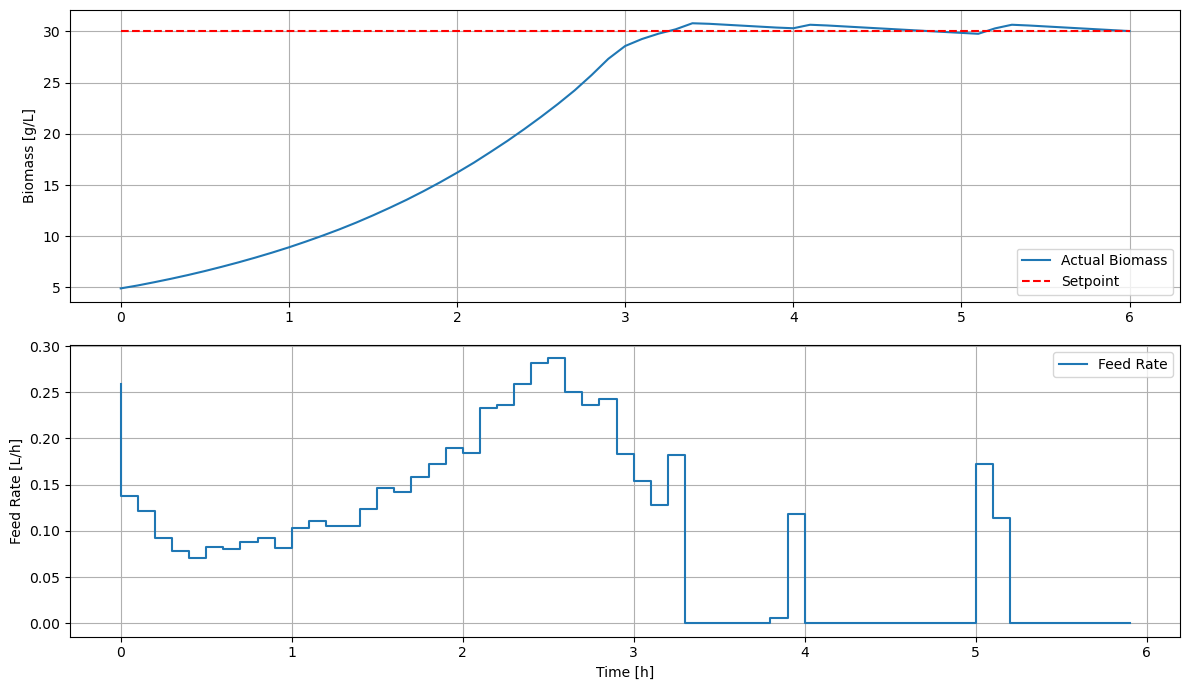

In [254]:
# ========================
# VISUALIZATION
# ========================
fig, axs = plt.subplots(2, 1, figsize=(12, 7))

# Biomass plot
time_axis = np.arange(0, At + dt, dt)
axs[0].plot(time_axis, X, label='Actual Biomass')
axs[0].plot(time_axis, [Cb_set(t) for t in time_axis], 'r--', label='Setpoint')
axs[0].set_ylabel('Biomass [g/L]')
axs[0].legend()
axs[0].grid()

# Feed rate plot
axs[1].step(np.arange(0, At, dt), F, label='Feed Rate')
axs[1].set_xlabel('Time [h]')
axs[1].set_ylabel('Feed Rate [L/h]')
axs[1].legend()
axs[1].grid()


plt.tight_layout()
plt.show()

In [249]:
noise_raw = np.random.normal(0, 1)  # check if ranom.seed works for reproducibility
print(noise_raw)


0.37642553115562943


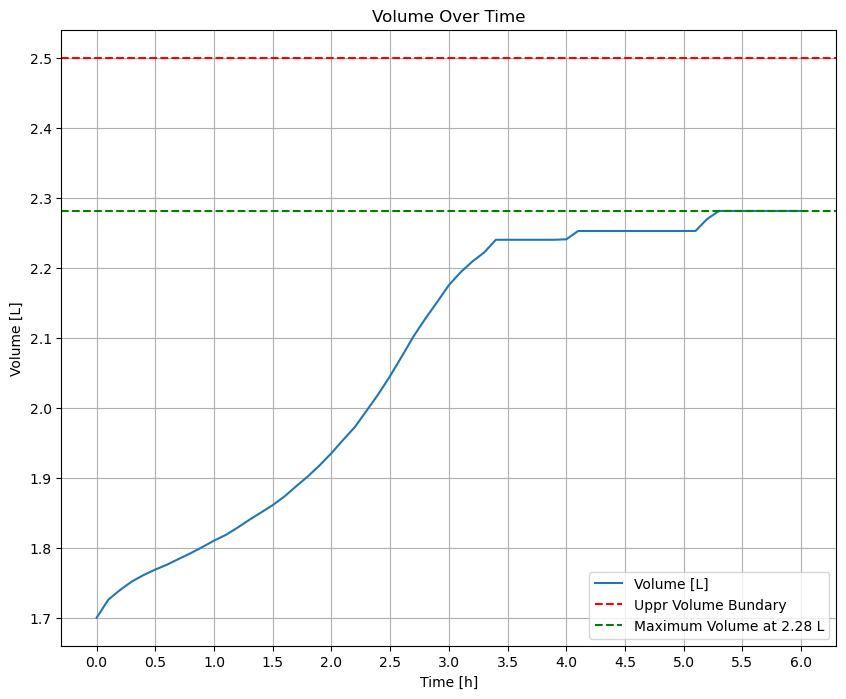

In [250]:
plt.figure(figsize=(10, 8))
plt.plot(time_axis,V,label='Volume [L]')
plt.axhline(Vmax, color='r', linestyle='--', label='Uppr Volume Bundary')
plt.axhline(max(V), color='g', linestyle='--', label=f'Maximum Volume at {max(V):.2f} L')
plt.xlabel('Time [h]')
plt.ylabel('Volume [L]')
plt.xticks(np.arange(0, At + dt, 0.5))
plt.legend()
plt.title('Volume Over Time')
plt.grid()
plt.show()

In [ ]:
previous_F_opt = F0 * np.ones(Np)  # Initial guess for first optimization

for step in range(SS):
            current_time = step * dt
            # Simulate measurement with noise
            X_measured = X[step] + np.random.normal(0, X[step] * biomass_noise_ratio)
            S_measured = S[step] + np.random.normal(0,max(1e-6, S[step] * substrate_noise_ratio))
            F_guess = np.append(previous_F_opt[1:], previous_F_opt[-1])
            # Solve MPC optimization
            res = minimize(
                cost_function,
                F_guess,
                args=(X_measured, S_measured, V[step], current_time),
                bounds=bnds,
                # constraints=volume_constraint,
                method="SLSQP",
            )
            
            previous_F_opt = res.x
            # Apply first control input
            F[step] = res.x[0]
            
            # Simulate real system with actual model
            sol = solve_ivp(
                actual_model,
                [current_time, current_time + dt],
                [X[step], S[step], V[step]],
                args=(F[step],),
                t_eval=[current_time,current_time + dt],
            )
            X[step+1], S[step+1], V[step+1] = sol.y[:, -1]

# EXPORT DATA

In [ ]:
MPC_data=[X,S,V,F]
MPC_df=pd.DataFrame(data=MPC_data).T
MPC_df.columns=["Biomass","Substrate","Volume","Feed"]   